In [1]:
from fastai.vision import *
from PIL import Image
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import tifffile
from fastai.vision.models.xresnet import *

In [2]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [3]:
path = 'data/eurosat-allbands/'

In [4]:
class TiffList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def open(self, fn):
        raw = tifffile.imread(str(fn))
        x = pil2tensor(raw,np.float32)
        return x

In [5]:
data = TiffList.from_folder(path)

In [6]:
def calculate_stats_eurosat_allbands(data):
    all_images = torch.zeros((27000, 13, 64, 64))
    for i, im in enumerate(data):
        all_images[i] = im
    
    stat_mean = all_images.mean(-1).mean(-1).mean(0)
    stat_std = all_images.std(-1).std(-1).std(0)
    
    return (stat_mean.tolist(), stat_std.tolist())

In [7]:
stats_eurosat_allbands = ([1353.73046875,
  1117.2020263671875,
  1041.8876953125,
  946.5513305664062,
  1199.1883544921875,
  2003.0101318359375,
  2374.01171875,
  2301.222412109375,
  732.1828002929688,
  12.099513053894043,
  1820.6893310546875,
  1118.1998291015625,
  2599.784912109375],
 [30.343395233154297,
  66.4549560546875,
  71.52734375,
  86.9700698852539,
  70.47565460205078,
  81.35286712646484,
  97.88168334960938,
  99.96805572509766,
  27.891748428344727,
  0.32882159948349,
  92.60734558105469,
  87.39993286132812,
  106.57888793945312])

In [8]:
data = data.split_by_rand_pct()
data = data.label_from_folder()
data = data.databunch()
data = data.normalize(stats_eurosat_allbands)

# Xresnet model

In [12]:
model = xresnet50(c_in=13, c_out=data.c)


In [13]:
learn = Learner(data, model, metrics=[accuracy])


In [14]:
learn.summary()


XResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 32, 32]         3,744      True      
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
ReLU                 [2048, 2, 2]         0          False     
______________________________________________________________________
Conv2d               [32, 32, 32]         9,216      True      
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
ReLU                 [2048, 2, 2]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         18,432     True      
______________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


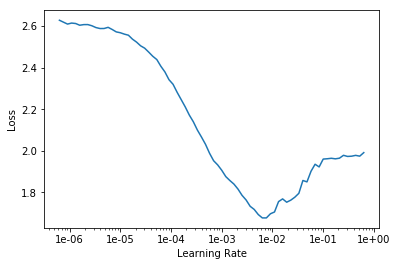

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 1e-3

learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.500946,0.495179,0.848333,00:19
1,0.368743,0.343056,0.890556,00:20
2,0.212753,0.143954,0.949444,00:19
3,0.106225,0.104400,0.964259,00:19
4,0.078917,0.076431,0.975000,00:19


## Test label smoothing

In [44]:
model = xresnet50(c_in=13, c_out=data.c)

learn = Learner(data, model, metrics=[accuracy],  loss_func = LabelSmoothingCrossEntropy())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


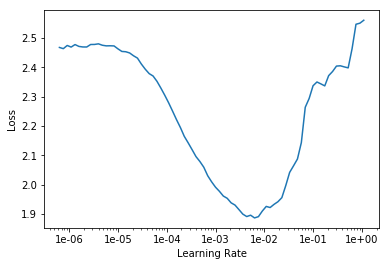

In [24]:
learn.lr_find()
learn.recorder.plot()

In [45]:
lr = 1e-3

learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.877314,0.808662,0.889074,00:19
1,0.819667,0.829704,0.883889,00:19
2,0.776229,0.708383,0.931111,00:19
3,0.720279,0.681520,0.933333,00:20
4,0.670894,0.645350,0.946111,00:20
5,0.657574,0.615966,0.960926,00:20
6,0.606520,0.590624,0.965185,00:20
7,0.589438,0.602417,0.959259,00:20
8,0.572418,0.564056,0.978333,00:20
9,0.549012,0.560137,0.978148,00:20


In [46]:
learn.export()

In [47]:
st = learn.model.state_dict()

In [48]:
torch.save(st, 'data/xres7_fastai_allbandsiw5')

## Test Resnet101

In [43]:
model = xresnet101(c_in=13, c_out=data.c)

learn = Learner(data, model, metrics=[accuracy],  loss_func = LabelSmoothingCrossEntropy())
lr = 1e-3

learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.881992,0.819512,0.890185,00:34
1,0.812112,0.761853,0.912222,00:34
2,0.764918,0.761987,0.914074,00:34
3,0.693610,0.745856,0.906111,00:34
4,0.654398,0.613509,0.957778,00:34
5,0.631040,0.638854,0.947778,00:34
6,0.606911,0.592391,0.966852,00:34
7,0.589538,0.577966,0.972593,00:34
8,0.565075,0.573151,0.968333,00:34
9,0.552160,0.559432,0.977037,00:34


## Test Mixup augmentation

In [28]:
model = xresnet50(c_in=13, c_out=data.c)

learn = Learner(data, model, metrics=[accuracy]).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


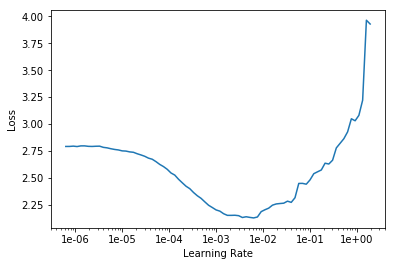

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.047968,0.457992,0.873333,00:20
1,0.928259,0.355216,0.900370,00:20
2,0.906137,0.318963,0.915185,00:20
3,0.885040,0.302464,0.918704,00:20
4,0.827090,0.269266,0.926111,00:20
5,0.804705,0.277637,0.924815,00:20
6,0.735159,0.201761,0.952593,00:20
7,0.741453,0.189141,0.953148,00:20
8,0.702630,0.195757,0.961481,00:20
9,0.672684,0.160730,0.964259,00:20


In [38]:
model = xresnet50(c_in=13, c_out=data.c)

learn = Learner(data, model, metrics=[accuracy],  loss_func = LabelSmoothingCrossEntropy()).mixup()



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


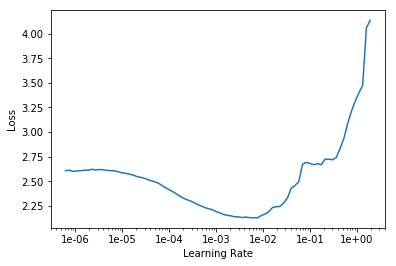

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.317459,0.858774,0.880370,00:20
1,1.215204,0.797638,0.901852,00:20
2,1.183566,0.751044,0.917963,00:20
3,1.146775,0.749931,0.912778,00:20
4,1.120949,0.699658,0.941111,00:20
5,1.095337,0.682743,0.949259,00:20
6,1.094504,0.716337,0.934444,00:20
7,1.068180,0.698861,0.937222,00:20
8,1.050496,0.645600,0.962963,00:20
9,1.031733,0.691773,0.937407,00:20


In [41]:
learn.fit(5, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.814892,0.541447,0.988148,00:20
1,0.822964,0.542796,0.987222,00:20
2,0.811508,0.542135,0.987222,00:20
3,0.816336,0.542627,0.986481,00:20
4,0.810137,0.542839,0.987222,00:20


In [32]:
model = xresnet50(c_in=13, c_out=data.c)

learn = Learner(data, model, metrics=[accuracy],  loss_func = LabelSmoothingCrossEntropy()).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


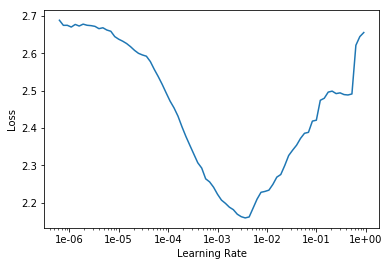

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(40, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.358265,0.916694,0.854815,00:20
1,1.238800,0.820622,0.895000,00:20
2,1.197607,0.786640,0.906852,00:20
3,1.171374,0.743479,0.918519,00:20
4,1.140731,0.748242,0.913704,00:20
5,1.131346,0.766675,0.915370,00:20
6,1.104772,0.679047,0.945741,00:20
7,1.071378,0.684643,0.946667,00:20
8,1.047676,0.665754,0.957407,00:20
9,1.031510,0.632077,0.965370,00:20


In [35]:
learn.fit(5, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.837869,0.546951,0.986852,00:20
1,0.840016,0.547322,0.987593,00:20
2,0.840494,0.547535,0.986481,00:20
3,0.837143,0.547750,0.987407,00:20
4,0.839233,0.544249,0.989444,00:21


In [37]:
learn.fit(5, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.834410,0.543370,0.988704,00:20
1,0.833044,0.543194,0.988704,00:20
2,0.829306,0.541930,0.988519,00:20
3,0.825978,0.542906,0.988519,00:20
4,0.825873,0.542561,0.988148,00:20
